In [3]:
# Cell 1: Imports and globals

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
# from imageio.v2 import imread  # or from matplotlib.pyplot import imread

patch_size = 16
W_z = None


In [4]:
# Cell 2: load_images

def load_images(image_dir="images"):
    """
    Load image patches and compute whitened data for ICA and standardized data for PCA.
    
    Parameters
    ----------
    image_dir : str
        Directory containing images named 1.jpg, 2.jpg, 3.jpg, 4.jpg
    
    Returns
    -------
    X_ica : np.ndarray
        Whitened and mean-centered data for ICA (shape: [patch_size^2, num_patches])
    X_pca : np.ndarray
        Standardized data for PCA (shape: [patch_size^2, num_patches])
    """
    global patch_size, W_z

    max_patches = 40000
    X_ica = np.zeros((patch_size * patch_size, max_patches), dtype=float)

    idx = 0
    for img_idx in range(1, 5):
        img_path = f"{image_dir}/{img_idx}.jpg"
        image = imread(img_path).astype(float)

        # Convert RGB → grayscale by averaging channels
        if image.ndim == 3:
            image = image.mean(axis=2)

        H, W = image.shape

        # Extract non-overlapping 16×16 patches
        for i in range(H // patch_size):
            for j in range(W // patch_size):
                patch = image[
                    i * patch_size:(i + 1) * patch_size,
                    j * patch_size:(j + 1) * patch_size
                ]
                X_ica[:, idx] = patch.reshape(-1)
                idx += 1

                if idx >= max_patches:
                    break
            if idx >= max_patches:
                break
    
    # Trim unused columns
    X_ica = X_ica[:, :idx]

    # ---- Whitening Step for ICA ----
    n = X_ica.shape[1]

    # Compute covariance (d × d)
    cov = (1.0 / n) * (X_ica @ X_ica.T)

    # Eigendecomposition
    eigvals, eigvecs = np.linalg.eigh(cov)

    eps = 1e-10
    D_inv_sqrt = np.diag((eigvals + eps) ** -0.5)

    # Whitening matrix W_z = E * D^{-1/2} * E^T
    W_z = eigvecs @ D_inv_sqrt @ eigvecs.T

    # Mean-center
    mean_vec = X_ica.mean(axis=1, keepdims=True)
    X_centered = X_ica - mean_vec

    # ICA data = whitened and scaled ×2
    X_ica_whitened = 2.0 * (W_z @ X_centered)

    # PCA data = standardized per feature
    std_vec = X_centered.std(axis=1, keepdims=True)
    std_vec[std_vec == 0] = 1.0  # avoid divide-by-zero

    X_pca_standardized = X_centered / std_vec

    return X_ica_whitened, X_pca_standardized

In [5]:
image_dir="./data/images"
X_ica, X_pca = load_images(image_dir)

print("PCA data shape:", X_pca.shape)
print("ICA data shape:", X_ica.shape)

PCA data shape: (256, 6144)
ICA data shape: (256, 6144)


In [6]:
# Cell 3: ICA implementation (corrected)
def ica(X, max_iter=200, tol=1e-5):
    """
    Perform ICA using FastICA algorithm (pure NumPy version).
    
    Parameters
    ----------
    X : np.ndarray
        Whitened data matrix of shape (n_samples, n_features)
    max_iter : int
        Maximum number of iterations
    tol : float
        Convergence tolerance
    
    Returns
    -------
    W : np.ndarray
        Unmixing matrix of shape (n_features, n_features)
    S : np.ndarray
        Estimated independent components, shape (n_samples, n_features)
    """
    n_samples, n_features = X.shape

    # Initialize random weights
    W = np.random.randn(n_features, n_features)

    # Decorrelate function
    def decorrelate(W):
        # Symmetric decorrelation
        s, u = np.linalg.eigh(W @ W.T)
        return (u @ np.diag(1.0 / np.sqrt(s)) @ u.T) @ W

    W = decorrelate(W)

    for i in range(max_iter):
        W_old = W.copy()
        
        # FastICA update
        WX = X @ W.T
        g = np.tanh(WX)
        g_prime = 1 - g ** 2
        W = (X.T @ g) / n_samples - np.mean(g_prime, axis=0) * W
        
        # Decorrelate
        W = decorrelate(W)

        # Check convergence
        lim = np.max(np.abs(np.abs(np.diag(W @ W_old.T)) - 1))
        if lim < tol:
            break

    # Estimated independent components
    S = X @ W.T
    return W, S

In [7]:
X = X_ica.T
print(X.shape)   # Should be (6144, 256)

(6144, 256)


In [8]:
# Run ICA
W, S = ica(X)

print("Unmixing matrix W shape:", W.shape)
print("Independent components S shape:", S.shape)

Unmixing matrix W shape: (256, 256)
Independent components S shape: (6144, 256)


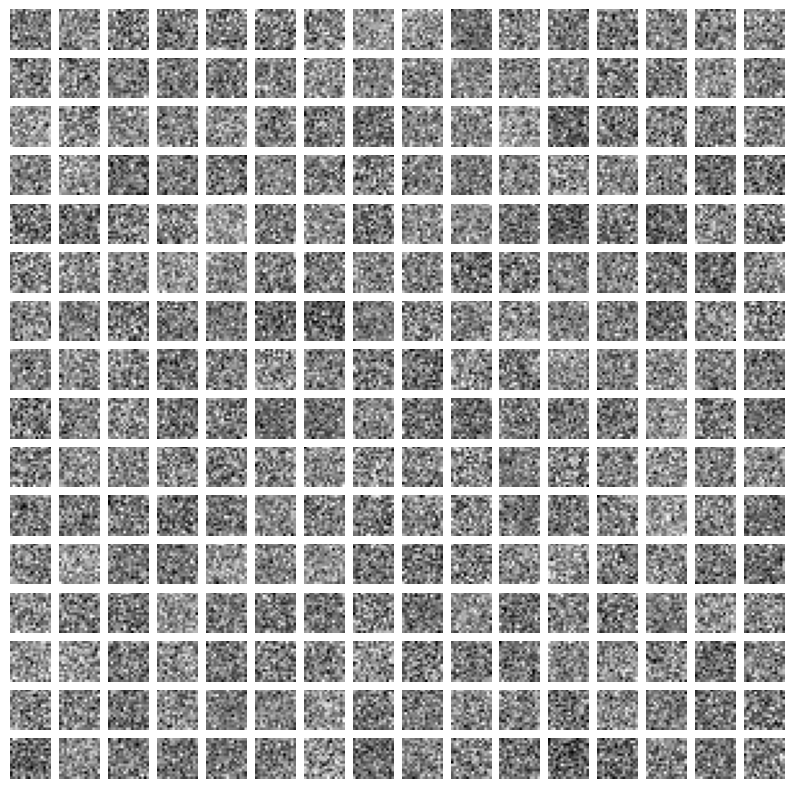

In [9]:
fig, axes = plt.subplots(16, 16, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(W[i].reshape(16, 16), cmap='gray')
    ax.axis("off")
plt.show()

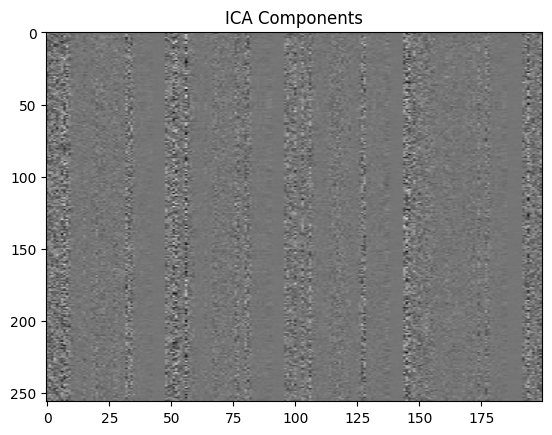

In [10]:
plt.imshow(S[:200].T, aspect='auto', cmap='gray')
plt.title("ICA Components")
plt.show()


In [20]:
# Cell 4: PCA function stub

def pca(X):
    """
    Principal Component Analysis
    
    Parameters
    ----------
    X : np.ndarray
        Data matrix of shape (d, n) where:
        - d = number of features (256 for 16x16 patches)
        - n = number of samples (~20,000 patches)
    
    Returns
    -------
    U : np.ndarray
        Matrix of principal components (eigenvectors), shape (d, d)
        Each COLUMN is a principal component (basis vector)
    """
    
    # Get dimensions
    d, n = X.shape
    print(f"Data shape: {d} features x {n} samples")
    
    # Compute covariance matrix
    # Cov = (1/n) * X * X^T
    # This is a d×d matrix showing variance/covariance between features
    cov = (1.0 / n) * (X @ X.T)
    print(f"Covariance matrix shape: {cov.shape}")
    
    # Eigendecomposition
    # For symmetric matrices, eigh is more efficient than eig
    # eigvals: variance along each principal component
    # eigvecs: the principal components (directions)
    eigvals, eigvecs = np.linalg.eigh(cov)
    print(f"Computed {len(eigvals)} eigenvalues")
    
    # Sort by eigenvalues (descending order)
    # Largest eigenvalue = direction of maximum variance
    idx = np.argsort(eigvals)[::-1]  # [::-1] reverses to descending
    
    # Reorder eigenvectors by importance
    U = eigvecs[:, idx]
    
    #Print variance explained by top components
    total_var = np.sum(eigvals)
    top_10_var = np.sum(eigvals[idx[:10]]) / total_var * 100
    print(f"Top 10 components explain {top_10_var:.2f}% of variance")
    
    return U

In [21]:
U = pca(X_pca)
print("PCA components U shape:", U.shape)

Data shape: 256 features x 6144 samples
Covariance matrix shape: (256, 256)
Computed 256 eigenvalues
Top 10 components explain 90.54% of variance
PCA components U shape: (256, 256)


In [14]:
# Cell 5: plot_ica_filters

def plot_ica_filters(W):
    """
    Plot ICA filters in a big grid.
    
    Parameters
    ----------
    W : np.ndarray
        Unmixing/filters matrix of shape (num_filters, patch_size^2)
    """
    global patch_size, W_z
    if W_z is None:
        raise ValueError("W_z is not set. Call load_images() first to compute W_z.")
    
    F = W @ W_z

    # Sort filters by 2-norm of rows of F.
    norms = np.linalg.norm(F, axis=1)
    idxs = np.argsort(norms)  # ascending order

    # Big image size: ((patch_size+1)*patch_size - 1)
    big_side = (patch_size + 1) * patch_size - 1
    big_filters = np.min(W) * np.ones((big_side, big_side))

    # Fill in each patch
    for i in range(patch_size):
        for j in range(patch_size):
            filter_idx = idxs[i * patch_size + j]
            filt = W[filter_idx, :].reshape(patch_size, patch_size)

            row_start = i * (patch_size + 1)
            row_end = row_start + patch_size
            col_start = j * (patch_size + 1)
            col_end = col_start + patch_size

            big_filters[row_start:row_end, col_start:col_end] = filt

    plt.figure()
    plt.imshow(big_filters, cmap="gray", aspect="equal")
    plt.axis("off")
    plt.show()


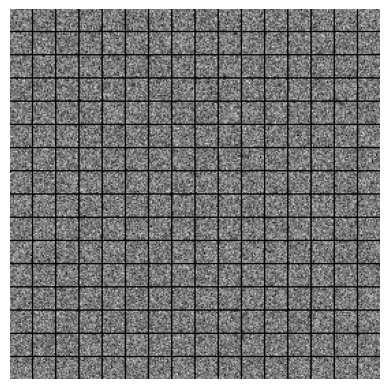

In [15]:
plot_ica_filters(W)

In [16]:
# Cell 6: plot_pca_filters

def plot_pca_filters(U):
    """
    Plot PCA filters in a big grid.
    
    Parameters
    ----------
    U : np.ndarray
        Matrix of principal components of shape (patch_size^2, patch_size^2),
        where each COLUMN is a filter.
    """
    global patch_size

    big_side = (patch_size + 1) * patch_size - 1
    big_filters = np.min(U) * np.ones((big_side, big_side))

    for i in range(patch_size):
        for j in range(patch_size):
            col_idx = i * patch_size + j
            filt = U[:, col_idx].reshape(patch_size, patch_size)

            row_start = i * (patch_size + 1)
            row_end = row_start + patch_size
            col_start = j * (patch_size + 1)
            col_end = col_start + patch_size

            big_filters[row_start:row_end, col_start:col_end] = filt

    plt.figure()
    plt.imshow(big_filters, cmap="gray", aspect="equal")
    plt.axis("off")
    plt.show()


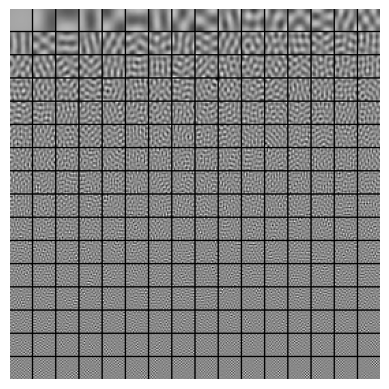

In [17]:
plot_pca_filters(U)